In [ ]:
### 모듈준비
! pip install opencv-python
! pip install cmake
! pip install dlib
### 모듈실행
import cv2
import matplotlib.pyplot as plt
import numpy as np

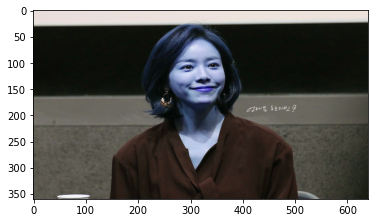

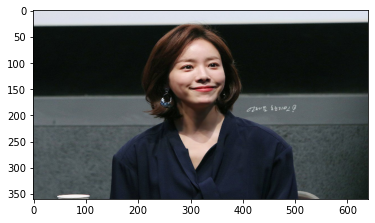

In [ ]:
### 이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/123.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

### 이미지 BGR에서 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기
dlib를 이용해 bounding box와 landmark찾기

In [ ]:
### dlib를 활용해 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸") # 이게 왜 있는거지?

🌫🛸


In [ ]:
### detecotr를 이용해 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib는 bgr로 이미지를 받기 때문에 cvtColor()를 이용해 opencv의 bgr이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid) 
print("🌫🛸")

🌫🛸


rectangles[[(270, 80) (378, 187)]]


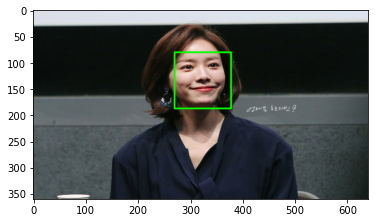

In [ ]:
### 얼굴 화면 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
[hint] 2, 36, 48, 30 번 인덱스를 이용

In [ ]:
#### 저장한 landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [ ]:
#### landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


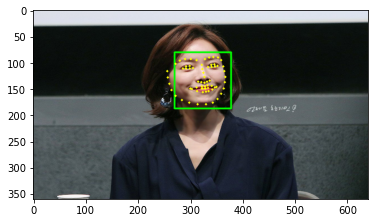

In [ ]:
#### 랜드마크 사진에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 이목구비 위치
![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-8-8.png)

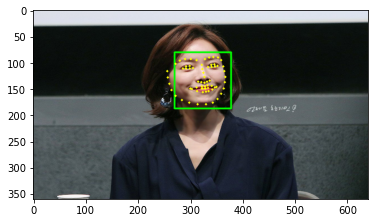

In [ ]:
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
landmark[33][1]

138

In [ ]:
#### 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0] 
    y = landmark[30][1] - dlib_rect.width() // 2
    w = landmark[30][0] - landmark[2][0]          
    h = landmark[48][1] - landmark[36][1]

    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h))

(327, 127)
(x,y) : (327,73)
(w,h) : (67,38)


#### 힌트를 괜히 준 게 아니다 생각하고 생각을 하고 몇번 해보니 아래에서 이번 셀에 있는 w, h값을 수염 크기로 받는 것을 보고
#### 고양이 수염 크기를 힌트로 준 것으로 생각했다.
#### 그래서 w, h는 고양이 수염 크기로 생각하고 가로, 세로를 힌트 준 값으로 조정했다.

In [ ]:
### 스티커 이미지 읽기
### 왕관 이미지를 읽고 윗 단계에서 계산한 w, h 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(38, 67, 3)


In [ ]:
refined_x = x - w // 2  # left
refined_y = y + h       # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (294,111)


#### refined_y = top : 사진보면 약 150정도가 코 위치이므로 y + h 111로 근접하게 가야함  
#### 원래는 y + w로 140에 맞추고 아래의 sticker_area = img_show[refined_y:] 에서 refined_y를 안 더해주고 shape값만 쓰려고 했는데 오류가 발생했다. 
#### 몇 번 시도 후에 refined_y를 더해주면 오류가 안나는 것을 알고 값들을 더해보다가 y + h로 했다.

## 이 이미지는 -값이 없기 때문에 crop 과정이 생략됨

In [ ]:
print(img_sticker.shape)

#img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

(38, 67, 3)


## Step 4. 스티커 적용하기
[hint] opencv 의 cv2.addWeighted() 를 참고

In [ ]:
print(refined_y)

111


In [ ]:
print(refined_x)

294


In [ ]:
# # -y 크기만큼 스티커를 crop
# (105, 224, 3)
# # 224-119 = 105

## 이 이미지는 -값이 없기 때문에 crop 과정이 생략됨

In [ ]:
print(img_sticker.shape)

(38, 67, 3)


In [ ]:
#### 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]


img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


#### 수염을 내리기 위해 값을 여러번 수정하다보니 맞는지는 모르겠지만 sticker_area는 변수명처럼 스티커가 붙을 위치인 것을 알 수 있었다.
#### 수염이 계속 안 내려왔지만 몇 번 수정해보고 sticker_area와 img_show 두개의 인자를 똑같이 다 맞추니깐 수염이 내려오는 것을 알 수 있었다.
#### 개인적으로 노드에서는 refined_y값인 0만 150으로 바꾸면 될 것 같았는데 0을 다른 숫자로 바꿔보니 계속 오류가 발생했고 내가 숫자를 넣는건 무의미..? 한 것 같았다.
#### 그래서 위에서 refined_y 값을 수정해보니 수염이 내려왔다.
#### 출력된 사진을 보면 한지민 코가 150정도에 있고 refined_y의 값 111 + shape[0]의 값 38 이므로 합이 149로 150의 위치에 잘 맞췄다. 


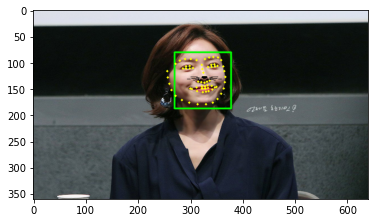

In [ ]:
### 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

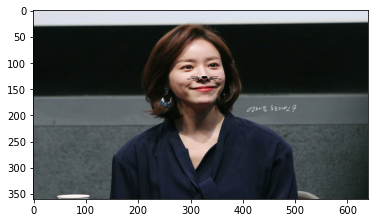

In [ ]:
#### bounding box와 landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

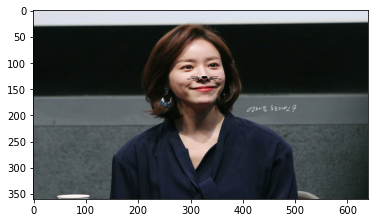

In [ ]:
# 불투명
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 바뀌는지 잘 모르겠어서 극단적으로 투명도 변경

------

# 사진 돌리기

In [ ]:
### 모듈준비
! pip install opencv-python
! pip install cmake
! pip install dlib
### 모듈실행
import cv2
import matplotlib.pyplot as plt
import numpy as np

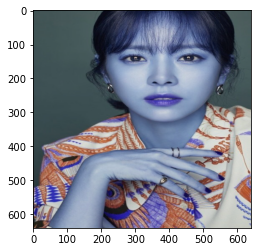

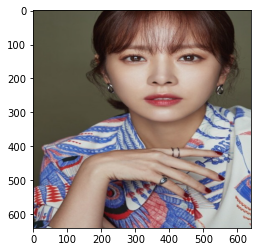

In [ ]:
### 이미지 불러오기
import os
import cv2 # cv2 모듈 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/123_2.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 640))    # 640x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
# img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
plt.imshow(img_bgr)
plt.show()

### 이미지 BGR에서 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기
dlib를 이용해 bounding box와 landmark찾기

In [ ]:
### dlib를 활용해 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸") # 이게 왜 있는거지?

🌫🛸


In [ ]:
### detecotr를 이용해 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib는 bgr로 이미지를 받기 때문에 cvtColor()를 이용해 opencv의 bgr이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid) 
print("🌫🛸")

🌫🛸


rectangles[[(205, 27) (526, 348)]]


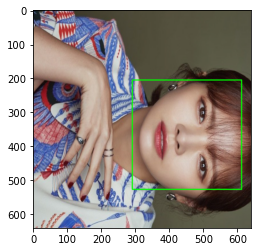

In [ ]:
### 얼굴 화면 출력
# 사진을 처음 부터 옆으로 돌리면 bounding box를 못 찾고 
# 이번 과정에서 눕혀야함
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
img_show_rgb = cv2.rotate(img_show_rgb, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전


plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
[hint] 2, 36, 48, 30 번 인덱스를 이용

In [ ]:
#### 저장한 landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [ ]:
#### landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


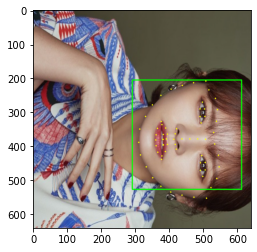

In [ ]:
#### 랜드마크 사진에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
img_show_rgb_90 = cv2.rotate(img_show_rgb, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
plt.imshow(img_show_rgb_90)
plt.show()

# 이목구비 위치
![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-8-8.png)

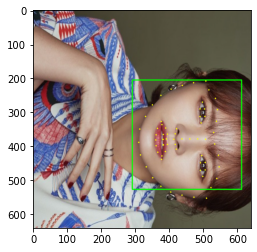

In [ ]:
plt.imshow(img_show_rgb_90)
plt.show()

In [ ]:
landmark[33][1]

226

In [ ]:
#### 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0] 
    y = landmark[30][1] - dlib_rect.width() // 2
    w = landmark[30][0] - landmark[2][0]
    h = landmark[48][1] - landmark[36][1]
    # w, h는 고양이 수염 크기
    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h))

(378, 202)
(x,y) : (378,41)
(w,h) : (157,121)


In [ ]:
### 스티커 이미지 읽기
### 왕관 이미지를 읽고 윗 단계에서 계산한 w, h 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(121, 157, 3)


In [ ]:
refined_x = x - w // 2  # left
refined_y = y + h
# 사진보면 약 400, 400 정도가 코 위치로 보이지만 옆으로 뒤집어놨기 때문에 y축 숫자가 반대로 바꿔서 계산해야함
# 그러므로 400에 150정도가 코 위치임

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (300,162)


In [ ]:
print(img_sticker.shape)

#img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

(121, 157, 3)


In [ ]:
# # -y 크기만큼 스티커를 crop
# (105, 224, 3)
# # 224-119 = 105

In [ ]:
# #### top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

# refined_y = 0
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

## Step 4. 스티커 적용하기

In [ ]:
print(refined_y)

162


In [ ]:
print(refined_x)

300


In [ ]:
print(img_sticker.shape)

(121, 157, 3)


In [ ]:
#### 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
sticker_area_90 = cv2.rotate(sticker_area, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전

### sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지다.
### refined_y의 좌표는 111 + shape[0]의 좌표는 38 합이 149 한지민 코가 149정도에 있음
### 그래서 그냥 그냥 sticker_area는 스티커가 붙을 위치로 해석

# #### 불투명도 조절

# cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
img_show_90 = cv2.rotate(img_show, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
### 걍 두개 똑같이 다 맞추니깐 나옴



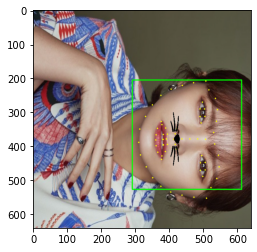

In [ ]:
# ### 이미지 출력
plt.imshow(cv2.cvtColor(img_show_90, cv2.COLOR_BGR2RGB))
plt.show()


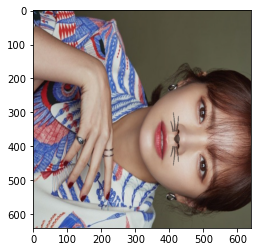

In [ ]:
#### bounding box와 landmark 제거 및 반투명
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
sticker_area_90 = cv2.rotate(sticker_area, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

# 누워있는 사진

In [ ]:
### 모듈준비
! pip install opencv-python
! pip install cmake
! pip install dlib
### 모듈실행
import cv2
import matplotlib.pyplot as plt
import numpy as np

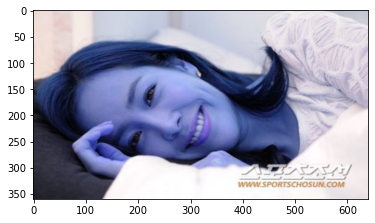

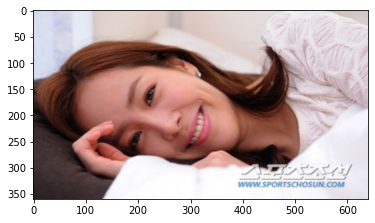

In [ ]:
### 이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/123_1.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서

img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관


plt.imshow(img_bgr)
plt.show()

### 이미지 BGR에서 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기
dlib를 이용해 bounding box와 landmark찾기

In [ ]:
### dlib를 활용해 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸") # 이게 왜 있는거지?

🌫🛸


In [ ]:
### detecotr를 이용해 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib는 bgr로 이미지를 받기 때문에 cvtColor()를 이용해 opencv의 bgr이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid) 
print("🌫🛸")

🌫🛸


rectangles[]


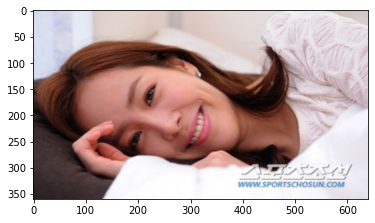

In [ ]:
### 얼굴 화면 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# img_show_rgb = cv2.rotate(img_show_rgb, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전

plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
[hint] 2, 36, 48, 30 번 인덱스를 이용

In [ ]:
#### 저장한 landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [ ]:
#### landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

IndexError: list index out of range

# 총평
이번 실습은 저번 IRIS 실습보다 난이도가 높았지만 이것 저것 해볼 수 있어서 더 재밌었다.
수염이 너무나도 안내려왔지만 마지막 이미지 출력 쪽에서 값을 바꾸니 내려왔다.

누워있는 사진도 수염을 붙이려 했으나 누워 있는 사진은 bounding box와 landmark가 나오지 않았다.

그래서 정상적인 이미지를 돌려서는 수염이 될까 궁금해서 해보니 됐다. 
할 때는 몰랐지만 총평 쓰면서 지금 생각해보니 정상적인 사진을 돌리는건 그냥 완성 후 사진과 수염만 돌리면 되는건데 왜 시도했는지 잘 모르겠다..
그래도 안 해본 것 보단 좋은 경험이라 생각한다.

누워있는 사진에 box와 landmark가 적용이 안되서 dlib.get_frontal_face_detector()에 대해서 조금 찾아보니 이 함수는? 정면만 인식해서 그런 것 같다. 그래서 누워있는 이미지를 돌려서 해봤는데 적용이 되질 않았다. 아직 시도는 해보지 않았지만 조금 더 식별하기 좋은? 뚜렷한 사진으로 해보면 가능하지 않을까? 생각한다. 

마지막으로 이번 exploration하면서 노드에 설명이 좀 부족하다 생각은 했지만 어쨋든 해결은 했다. 그리고 이전 iris보단 이것 저것 해볼 수 있는 게 많아서 재밌게 했다~!

~~추가로 19일 노트북 수령 후 설정하고 사진을 더 실험해보려 했는데 지금 노트북이 안된다... 공지사항을 못보고  nvidia 드라이버를 깐 게 문제인 것 같다... 일단 먼저 깃허브에 과제 올리고 노트북을 해결 해야할 것 같다...~~

정보문화진흥원에 가서 퍼실님들이 해결해줬다... 도움주신 퍼실님들 너무 감사드립니다~!!!!